In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import time
import shutil

import urllib

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [176]:
import hosts
import decals

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy import table
from astropy.table import Table
from astropy.io import fits

from astropy.utils import data

import tqdm
from IPython import display

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (14, 8)

# Load the bricks and SAGA hosts

In [5]:
bricks = Table.read('decals_dr4/survey-bricks.fits.gz')
bricksdr3 = Table.read('decals_dr3/survey-bricks-dr3.fits.gz')
bricksdr4 = Table.read('decals_dr4/survey-bricks-dr4.fits.gz')

In [6]:
paper1nsas_comp = [166313,147100,165536,61945,132339,149781,33446,150887]
paper1nsas_incomp = [161174,85746,145729,140594,126115,13927,137625,129237]
paper1nsas = paper1nsas_comp + paper1nsas_incomp

In [7]:
hostobjs = hosts.get_saga_hosts_from_google()
paperhosts = [h for h in hostobjs if h.nsaid in paper1nsas]
assert len(paperhosts) == len(paper1nsas)

paperhostscs = SkyCoord([h.coords for h in paperhosts])
paperhostsbyname = {h.name:h for h in paperhosts}

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [8]:
host_bricks_3 = decals.find_host_bricks(paperhosts, bricksdr3, bricks)
host_bricks_4 = decals.find_host_bricks(paperhosts, bricksdr4, bricks)

host_bricks_dct = {3:host_bricks_3, 4:host_bricks_4}

# Build combined catalogs for every host

In [9]:
for hostobj in paperhosts:
    hbricks = host_bricks_3[host_bricks_3['closest_host_name'] == hostobj.name]
    catfn = 'decals_dr3/'

In [10]:
def load_host_catalog(hostobj, drnum):
    host_bricks = host_bricks_dct[drnum]
    tabs = []
    for brick in host_bricks[host_bricks['closest_host_name'] == hostobj.name]:
        catfn = 'decals_dr{}/catalogs/tractor-{}.fits'.format(drnum, brick['brickname'])
        cat = Table.read(catfn)
        cat['objname'] = ['{}-{}'.format(row['brickname'], row['objid']) for row in cat]
        tabs.append(cat)
    if tabs:
        return table.vstack(tabs)

In [11]:
for hostobj in tqdm.tqdm_notebook(paperhosts):
    hostobj.cats3 = load_host_catalog(hostobj, 3)
    
[(hostobj.name, len(hostobj.cats3)) for hostobj in paperhosts if hostobj.cats3 is not None]

[('Odyssey', 145041),
 ('Alice', 237279),
 ('Gilgamesh', 94874),
 ('AnaK', 182540),
 ('Dune', 231112),
 ('Sopranos', 286959),
 ('Narnia', 158462),
 ('Bandamanna', 59030),
 ('OBrother', 17901),
 ('Catch22', 3951),
 ('HarryPotter', 44918),
 ('Oz', 41667),
 ('ScoobyDoo', 94704),
 ('Othello', 138656)]

In [12]:
for hostobj in tqdm.tqdm_notebook(paperhosts):
    hostobj.cats4 = cat = load_host_catalog(hostobj, 4)
    
[(hostobj.name, len(hostobj.cats4)) for hostobj in paperhosts if hostobj.cats4 is not None]

[('MobyDick', 86799), ('StarTrek', 86644)]

## Compute surface brightnesses

In [96]:
for host in tqdm.tqdm_notebook(paperhosts):
    for cat in (host.cats3, host.cats4):
        if cat is not None:
            decals.mags_catalog(cat)
            decals.aperture_sbs_catalog(cat, bandname='r')
            decals.interpolate_catalog_sb(cat, loopfunc=lambda x: tqdm.tqdm_notebook(x, leave=False))

# Look at some *example* catalogs

In [220]:
cat = hostobjs[0].cats3

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


nlowsb= 130


2473p195-1618decam_mag_r=20.6230049133sbeff_r=25.6991526205,2473p195-5075decam_mag_r=20.5482368469sbeff_r=32.9442292741,2474p197-1140decam_mag_r=20.1419849396sbeff_r=24.748879913,2474p197-2516decam_mag_r=19.0669574738sbeff_r=26.3829239957
2474p197-2517decam_mag_r=16.4463367462sbeff_r=25.4298811455,2474p197-5046decam_mag_r=20.9373626709sbeff_r=24.6752072313,2474p202-1515decam_mag_r=20.8266334534sbeff_r=24.8979054456,2474p202-3300decam_mag_r=20.6556682587sbeff_r=25.6898729449
2474p202-3939decam_mag_r=20.1394519806sbeff_r=24.7920350277,2475p192-18decam_mag_r=17.6461143494sbeff_r=27.8494848383,2475p192-3452decam_mag_r=20.3262405396sbeff_r=24.9859870956,2475p192-3937decam_mag_r=20.5478630066sbeff_r=24.513995654
2475p192-4601decam_mag_r=19.4910984039sbeff_r=25.3487394989,2476p195-224decam_mag_r=20.8897342682sbeff_r=24.6096842335,2476p195-769decam_mag_r=20.8116779327sbeff_r=24.7692684095,2476p195-900decam_mag_r=20.6125926971sbeff_r=24.7582576781
2476p202-450decam_mag_r=20.586271286sbeff_r=24.5934065751,2476p202-715decam_mag_r=20.3857479095sbeff_r=37.2588173046,2476p202-1475decam_mag_r=20.8264770508sbeff_r=24.8880903366,2476p202-2733decam_mag_r=20.8018913269sbeff_r=24.5035624766
2477p192-3decam_mag_r=18.5842418671sbeff_r=24.7082065478,2477p192-3875decam_mag_r=20.6281089783sbeff_r=25.03263113,2477p192-4079decam_mag_r=20.5489044189sbeff_r=24.5098781165,2477p192-4162decam_mag_r=19.7526130676sbeff_r=24.8813608147
2477p197-759decam_mag_r=18.2702465057sbeff_r=31.1301897295,2478p195-2590decam_mag_r=20.9697761536sbeff_r=31.8439584193,2478p195-4282decam_mag_r=20.7429084778sbeff_r=26.549063482,2478p200-6decam_mag_r=20.3502197266sbeff_r=25.4277524727
2478p200-4396decam_mag_r=20.6079826355sbeff_r=24.5260340332,2478p205-6decam_mag_r=20.8667869568sbeff_r=25.3154546826,2478p205-19decam_mag_r=18.78789711sbeff_r=31.6678057762,2478p205-86decam_mag_r=20.5476074219sbeff_r=25.3847165959
2478p205-1854decam_mag_r=16.5158500671sbeff_r=24.9337533247,2478p205-2444decam_mag_r=20.9407958984sbeff_r=26.6223755973,2478p205-3609decam_mag_r=20.8826332092sbeff_r=25.6255385359,2479p197-29decam_mag_r=20.3775558472sbeff_r=25.6079593966
2479p197-563decam_mag_r=20.5242118835sbeff_r=25.4743901636,2479p197-714decam_mag_r=20.6493434906sbeff_r=25.3186545183,2479p197-2111decam_mag_r=20.6180858612sbeff_r=24.5354889939,2479p197-3695decam_mag_r=20.9754238129sbeff_r=24.641584166
2479p197-4030decam_mag_r=20.6593570709sbeff_r=25.3495706953,2479p197-4369decam_mag_r=20.1378555298sbeff_r=24.7682002339,2479p202-354decam_mag_r=20.5389919281sbeff_r=24.6013505625,2479p202-640decam_mag_r=20.5016899109sbeff_r=25.2728902649


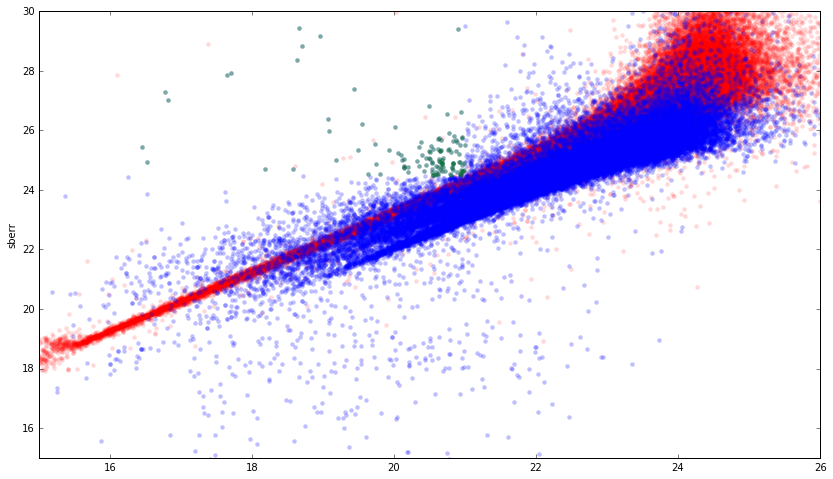

In [226]:
fig, ax1 = plt.subplots(1,1)

cat['decam_mag_r'] = cat['decam_mag'][:, 2]

psfs = cat['type'] == 'PSF '

lowsb_saga = (cat['decam_mag'][:, 2] < 21) & (cat['sbeff_r']>24.5) & ~psfs
print('nlowsb=', np.sum(lowsb_saga))


ax1.scatter(cat['decam_mag_r'][psfs], cat['sbeff_r'][psfs], alpha=.15, lw=0, c='r')
ax1.scatter(cat['decam_mag_r'][~psfs], cat['sbeff_r'][~psfs], alpha=.25, lw=0)
ax1.scatter(cat['decam_mag_r'][lowsb_saga], cat['sbeff_r'][lowsb_saga], alpha=.35, lw=0, c='g')
ax1.set_ylabel('sberr')    
ax1.set_xlim(15, 26)
ax1.set_ylim(15, 30)

decals.show_decals_objects_in_nb(cat[lowsb_saga], 4, info_cols=['decam_mag_r', 'sbeff_r'])

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


nlowsb= 327


2473p195-127decam_mag_r=20.8561553955sb_r_0p5=25.0983657837,2473p195-129decam_mag_r=20.0291461945sb_r_0p5=25.2835922241,2473p195-1618decam_mag_r=20.6230049133sb_r_0p5=24.6586551666,2473p195-2022decam_mag_r=20.3431911469sb_r_0p5=25.2137126923
2473p195-2422decam_mag_r=20.6702613831sb_r_0p5=24.6174163818,2473p195-3363decam_mag_r=18.9956512451sb_r_0p5=inf,2473p195-4911decam_mag_r=20.2045402527sb_r_0p5=24.5949401855,2473p195-4913decam_mag_r=19.9019088745sb_r_0p5=25.4201946259
2473p195-5042decam_mag_r=20.5985565186sb_r_0p5=inf,2473p195-5075decam_mag_r=20.5482368469sb_r_0p5=inf,2474p197-93decam_mag_r=18.9862003326sb_r_0p5=25.9524307251,2474p197-97decam_mag_r=19.5778980255sb_r_0p5=25.7213115692
2474p197-1784decam_mag_r=20.645275116sb_r_0p5=25.5897464752,2474p197-2516decam_mag_r=19.0669574738sb_r_0p5=inf,2474p197-2517decam_mag_r=16.4463367462sb_r_0p5=inf,2474p197-3210decam_mag_r=19.8407001495sb_r_0p5=26.2240562439
2474p197-3347decam_mag_r=20.6846256256sb_r_0p5=25.8355293274,2474p197-4997decam_mag_r=19.6404800415sb_r_0p5=25.3579006195,2474p197-5009decam_mag_r=20.1795005798sb_r_0p5=25.368927002,2474p197-5046decam_mag_r=20.9373626709sb_r_0p5=24.9803638458
2474p202-998decam_mag_r=20.9338932037sb_r_0p5=25.5925235748,2474p202-1708decam_mag_r=18.9066390991sb_r_0p5=24.521188736,2474p202-1786decam_mag_r=19.0919342041sb_r_0p5=25.2647647858,2474p202-1788decam_mag_r=20.2019176483sb_r_0p5=24.7740402222
2474p202-1789decam_mag_r=20.7715206146sb_r_0p5=25.7812747955,2474p202-1790decam_mag_r=20.4075641632sb_r_0p5=24.8929042816,2474p202-1791decam_mag_r=19.3581619263sb_r_0p5=24.9147644043,2474p202-1795decam_mag_r=19.2289543152sb_r_0p5=25.4013633728
2474p202-1797decam_mag_r=20.5261764526sb_r_0p5=25.2127971649,2474p202-1799decam_mag_r=19.5932693481sb_r_0p5=25.5670795441,2474p202-1801decam_mag_r=20.9549427032sb_r_0p5=26.502456665,2474p202-1802decam_mag_r=20.0278568268sb_r_0p5=24.9870071411
2474p202-2148decam_mag_r=20.9837017059sb_r_0p5=25.8477611542,2474p202-2958decam_mag_r=20.0272808075sb_r_0p5=25.9942092896,2474p202-3517decam_mag_r=20.8244762421sb_r_0p5=25.7510490417,2474p202-4286decam_mag_r=20.5537605286sb_r_0p5=24.6398296356
2475p192-15decam_mag_r=18.1825294495sb_r_0p5=inf,2475p192-18decam_mag_r=17.6461143494sb_r_0p5=inf,2475p192-983decam_mag_r=19.1561374664sb_r_0p5=inf,2475p192-1657decam_mag_r=20.7908496857sb_r_0p5=27.9448318481
2475p192-2340decam_mag_r=20.8633861542sb_r_0p5=27.7422943115,2475p192-3452decam_mag_r=20.3262405396sb_r_0p5=25.7429885864,2475p192-4484decam_mag_r=20.0096931458sb_r_0p5=25.2649345398,2475p192-4601decam_mag_r=19.4910984039sb_r_0p5=inf


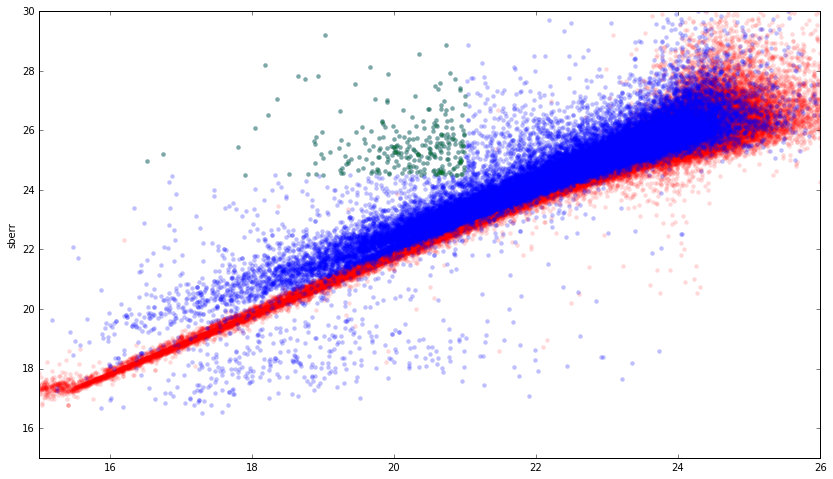

In [227]:
fig, ax1 = plt.subplots(1,1)

cat['decam_mag_r'] = cat['decam_mag'][:, 2]

psfs = cat['type'] == 'PSF '

lowsb_saga = (cat['decam_mag'][:, 2] < 21) & (cat['sb_r_0p5']>24.5) & ~psfs
print('nlowsb=', np.sum(lowsb_saga))

ax1.scatter(cat['decam_mag'][psfs, 2], cat['sb_r_0p5'][psfs], alpha=.15, lw=0, c='r')
ax1.scatter(cat['decam_mag'][~psfs, 2], cat['sb_r_0p5'][~psfs], alpha=.25, lw=0)
ax1.scatter(cat['decam_mag'][lowsb_saga, 2], cat['sb_r_0p5'][lowsb_saga], alpha=.35, lw=0, c='g')
ax1.set_ylabel('sberr')    
ax1.set_xlim(15, 26)
ax1.set_ylim(15, 30)

decals.show_decals_objects_in_nb(cat[lowsb_saga], 4, info_cols=['decam_mag_r', 'sb_r_0p5'])